# Рабочий ноутбук для решения задачи предсказания территории на которой находится торговая точка

## Входные данные

Данные поступают из двух файлов, которые формируются в существующей системой отчетности. В процессе обработки файлы могут быть объединены по полю “Код торговой точки”.
#### Файл Coordinates.xlsx
Файл содержит координаты торговых точек. Не все торговые точки имеют координаты. В процессе подготовки данных для обучения модели, точкам без координат будут назначены усредненные координаты соседних точек, которые находятся в том-же населенном пункте, что и точка без координат.
#### Файл Report Territory Management.xlsx
Данный файл является специальным отчетом, который требуется для работы оператора процесса, а также является входным файлом для последующего расчета. Файл содержит следующую информацию по точкам:
- Иерархия дистрибьюторов (Регион - Дистрибьютор - Филиал)
- Иерархия сотрудников
- Адресный классификатор (пять уровней)
- Характеристики точки: Сеть, Тир, Сегмент, Формат и т.п.
- Информация о посещении точки
- Код филиала на территории которого находится торговая точка (этот код необходимо предсказать, если отсутствует)

## Анализ и подготовка данных

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from pprint import pprint
from time import time

coord_file = 'Coordinates.xlsx'
report_file = 'Report Territory Management.xlsx'

### Координаты точек

Посмотрим на файл с координатами точек. Видим, что в файле содержится 435 тысяч записей без пустых значений.

In [2]:
# Загрузка файла с кординатами в DataFrame
df_coor = pd.read_excel(coord_file)
df_coor.columns = ['SWE_Store_Key','Latitude','Longitude']
df_coor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435419 entries, 0 to 435418
Data columns (total 3 columns):
SWE_Store_Key    435419 non-null int64
Latitude         435419 non-null float64
Longitude        435419 non-null float64
dtypes: float64(2), int64(1)
memory usage: 10.0 MB


Но что с валидностью значений? Необходимо учитывать, что допустимые значения широты находятся в диапазоне от -90 до +90, а значения долготы - в диапазоне от -180 до +180. Откинем недопустимые значения. Как видим, их не много.

In [3]:
# Оставить только допустимые координаты (широта -90...+90, долгота -180..+180)
init_num = df_coor.shape[0]
df_coor = df_coor[(df_coor['Latitude']>=-90) & (df_coor['Latitude']<=90)]
df_coor = df_coor[(df_coor['Longitude']>=-180) & (df_coor['Longitude']<=180)]
print('Валидных значений: {0}, некорректных значений: {1}'.format(df_coor.shape[0], init_num - df_coor.shape[0]))

Валидных значений: 435411, некорректных значений: 8


Беря во внимание информацию из Википедии о крайних точках Российской Федерации (https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B0%D0%B9%D0%BD%D0%B8%D0%B5_%D1%82%D0%BE%D1%87%D0%BA%D0%B8_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8), отбросим точки из других стран (берем с запасом). Осталось 396 тысяч точек с координатами

In [4]:
# Оставить только точки, с координатами в РФ
df_coor = df_coor[(df_coor['Latitude']>40)&(df_coor['Latitude']<82)]
df_coor = df_coor[((df_coor['Longitude']>=10)&(df_coor['Longitude']<180)) | \
    ((df_coor['Longitude']>=-180)&(df_coor['Longitude']<-160))]
print('Всего данных по точкам  в РФ: {0}'.format(df_coor.shape[0]))

Всего данных по точкам  в РФ: 396144


Посмотрим на распределение значений на графике типа Box & Whiskers. Получается медианное значение широты 55, а для долготы 50, с очевидно значительно меньшим количеством точек на крайних границах, которые не являются выбросами, в данном случае. Распределение не нормальное.

Text(0.5, 1.0, 'Долгота')

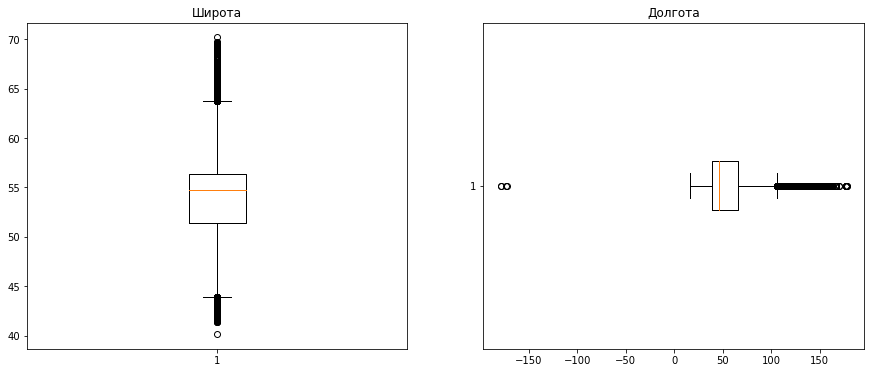

In [5]:
# Нарисовать графики типа Box & Whiskers
fig, axes = plt.subplots(1,2, figsize=(15,6))
axes[0].boxplot(df_coor['Latitude'].values)
axes[0].set_title('Широта')
axes[1].boxplot(df_coor['Longitude'].values, vert=False)
axes[1].set_title('Долгота')

### Информация по торговым точкам

Теперь перейдем к рассмотрению файла с основной информацией по торговым точкам. Как видно, информация по точке, полученная из справочников с основными мастер-данными, кажется полной (иерархия дистрибьюторов, иерархия сотрудников, информация по сети и точке, а также адресный классификатор), то есть признаки не содержат пропущенных значений.

In [6]:
# Загрузка файла с территориями точек в DataFrame и переименование столбцов для удобной работы
df_terr = pd.read_excel(report_file, skiprows=1)
df_terr.columns = ['Region','Distrib','Office','FFDSL','TSE_MTDE','Level_Torg_Region1','Level_Torg_Region2',
    'Filial_Name','Filial_Ship_To','Chain_Type','Chain_Name','Chain_Id','Chain_Chain_Tier_MWC',
    'Chain_Chain_Sub_Tier_MWC','SWE_Store_Key','Store_Status','Outlet_Name','Channel_Name_2018',
    'Outlet_Type_2018','Trade_Structure','From_Dc','Segment_MWC_Segment_Name','Cluster_MWC',
    'Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4','Kladr_level_5','LSV_WWY','LSV_CHOCO',
    'LSV_MWC','Covering_Outlet_id','General_Duplicate','Ship_To_Visited','Filial_Visited',
    'Ship_to_Name_TO_BE','Region_loaded_RSS','Ship_to_TO_BE_Name_loaded_RSS','SHIP_TO_RSS',
    'Ship_to_Code_TO_BE','DC','Changed','Change_Period']

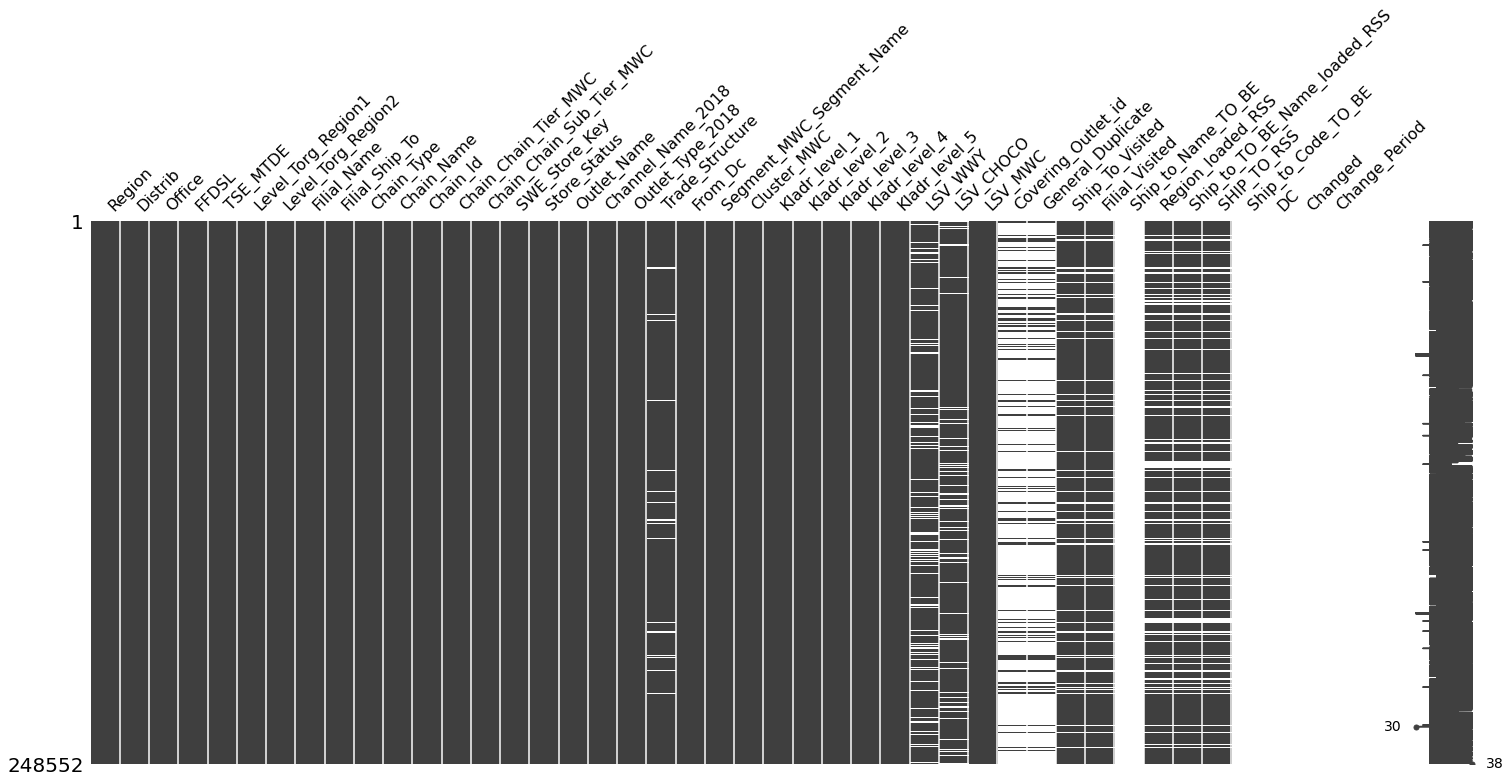

In [7]:
msno.matrix(df_terr)

Теперь удалим поля с названиями, для которых имеются соответствующие коды, а также поля без значений. Также нужно убрать информацию о продажах и визитах в точку (LSV, _Visited), так как это информация о последнем визите одного из дистрибьюторов в точку (а нам известно, что точку могут посещать несколько дистрибьюторов).

In [8]:
df_terr = df_terr[['SWE_Store_Key','Region','Distrib','Office','FFDSL','TSE_MTDE','Level_Torg_Region1',
    'Level_Torg_Region2','Filial_Name','Filial_Ship_To','Chain_Type','Chain_Id','Chain_Chain_Tier_MWC',
    'Chain_Chain_Sub_Tier_MWC','Channel_Name_2018','Outlet_Type_2018','Trade_Structure','From_Dc',
    'Segment_MWC_Segment_Name','Cluster_MWC','Covering_Outlet_id','General_Duplicate','SHIP_TO_RSS',
    'Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4','Kladr_level_5']]

Также от бизнеса получена информация, что в данных содержится информация о точках-дубликатах и определен способ оставить только основные (актуальные) точки

In [9]:
df_terr = df_terr[df_terr['General_Duplicate']!='Дубликат']
df_terr.drop(['Covering_Outlet_id','General_Duplicate'], axis=1, inplace=True)

Посмотрим на признак SHIP_TO_RSS, смысл которого - это код адреса доставки (должен быть целым числом определенной длины). По условиям задачи необходимо предсказать значение SHIP_TO_RSS (это примерно 10% от общего числа точек в отчете).

In [10]:
# В отдельном DataFrame подсчитать длину поля SHIP_TO_RSS,
# а затем сгруппировать по длине и вывести первое значение из каждой группы
ship = df_terr[['SHIP_TO_RSS']]
ship.loc[~ship['SHIP_TO_RSS'].isna(),'Length'] = \
    ship.loc[~ship['SHIP_TO_RSS'].isna()].SHIP_TO_RSS.apply(lambda x: len(str(x).strip()))
ship.groupby('Length').SHIP_TO_RSS.first()

Length
8.0                            10340352
19.0                10342443 , 10430024
30.0     10262975 , 10428588 , 10432783
Name: SHIP_TO_RSS, dtype: object

Задан дополнительный вопрос к бизнесу, почему для некоторых точек идёт два или три кода доставки, и получен ответ, что нужно использовать только первый код.

In [11]:
# SHIP_TO_RSS взять первые 8 символов и преобразовать к типу int
df_terr.loc[~df_terr['SHIP_TO_RSS'].isna(),'SHIP_TO_RSS'] = \
    df_terr.loc[~df_terr['SHIP_TO_RSS'].isna()]['SHIP_TO_RSS'].apply(lambda x: int(x[:9]))

Объединим отчет по территориям с координатами.

In [12]:
df = pd.merge(df_terr, df_coor, on='SWE_Store_Key', how='left')
del df_terr
del df_coor

Поскольку для каждой точки известен адрес, можно воспользоваться этой информацией, чтобы приблизительно восстановить координаты для точек с отсутствующими координатами. Для этого с бизнесом согласован алгоритм, при котором точкам без координат будут назначены усредненные координаты соседних точек, которые находятся в том-же населенном пункте, что и точка без координат. В случае отсутствия соседей в населенном пункте будет использоваться более высокий уровень адресного классификатора. После этого можно избавиться от адресного классификатора.

In [13]:
%%time
df['Latitude'].replace(0, np.NaN, inplace=True)
df['Longitude'].replace(0, np.NaN, inplace=True)
df['isCoord'] = ~( (df['Latitude'].isna()) | (df['Longitude'].isna()) )

kladr_lat_grouped = df[df['isCoord']==1].groupby(['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4']).Latitude.mean()
kladr_lon_grouped = df[df['isCoord']==1].groupby(['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4']).Longitude.mean()


def get_avg_coordinate(row, kladr_grouped):
    """
    Вернуть среднюю координату населенного пункта, области, региона или страны. Используем функции
    multiindex.isin().any(), чтобы проверить, что в Series имеется индекс для всех 4-х уровней
    и вернуть значение. В случае отсутствия индекса, отрубить последний уровень в индексе и проверить
    индекс для 3-х уровней и т.д.

    Parameters:
    row (Series): ['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4'] для которых нужно
        получить координату
    kladr_grouped (Series): с мультииндексом (['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4'])
        который содержит значения координаты для 4-х уровней из адресного классификатора
        
    Returns:
    float: Координата

    """
    try:
        if kladr_grouped.index \
                .isin([(row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3'],row['Kladr_level_4'])]).any():
            return kladr_grouped[row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3'],row['Kladr_level_4']]
        elif kladr_grouped.index.droplevel(['Kladr_level_4']) \
                .isin([(row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3'])]).any():
            return kladr_grouped[row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3']].mean()
        elif kladr_grouped.index.droplevel(['Kladr_level_3','Kladr_level_4']) \
                .isin([(row['Kladr_level_1'],row['Kladr_level_2'])]).any():
            return kladr_grouped[row['Kladr_level_1'],row['Kladr_level_2']].mean()
        elif kladr_grouped.index.droplevel(['Kladr_level_2','Kladr_level_3','Kladr_level_4']) \
                .isin([(row['Kladr_level_1'])]).any():
            return kladr_grouped[row['Kladr_level_1']].mean()
        else:
            return 0
    except:
        print(row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3'],row['Kladr_level_4'])
        raise KeyError


df.loc[df['isCoord']==0,'Latitude'] = \
    df.loc[df['isCoord']==0][['SWE_Store_Key','Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4']].apply( \
        get_avg_coordinate, args=(kladr_lat_grouped,), axis=1)

df.loc[df['isCoord']==0,'Longitude'] = \
    df.loc[df['isCoord']==0][['SWE_Store_Key','Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4']].apply( \
        get_avg_coordinate, args=(kladr_lon_grouped,), axis=1)

Wall time: 3min 39s


In [14]:
df.drop(['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4','Kladr_level_5'], axis=1, inplace=True)
df['isTrain'] = ~ df['SHIP_TO_RSS'].isna()

In [15]:
df_init = df.copy()

### Анализ целевой переменной SHIP_TO_RSS

Почти подошли к построению модели. Поскольку искомый признак SHIP_TO_RSS это не непрерывная величина, а возможные фиксированные значения, то наша задача сводится к задаче мультиклассовой классификации. То есть необходимо обучить модель показывать наиболее вероятный код SHIP_TO_RSS по входным признакам.

Что здесь может пойти не так? Например, если в данных не будет хватать примеров для успешного обучения по какому-то SHIP_TO_RSS. Давайте поищем такие случаи, при которых количество кодов для обучения меньше 25. Мы будем сообщать пользователю, о такой проблеме, а не будем пытаться угадать. Таких кодов всего 11.

Text(0.5, 1.0, 'Коды доставки с количеством точек меньшим 25')

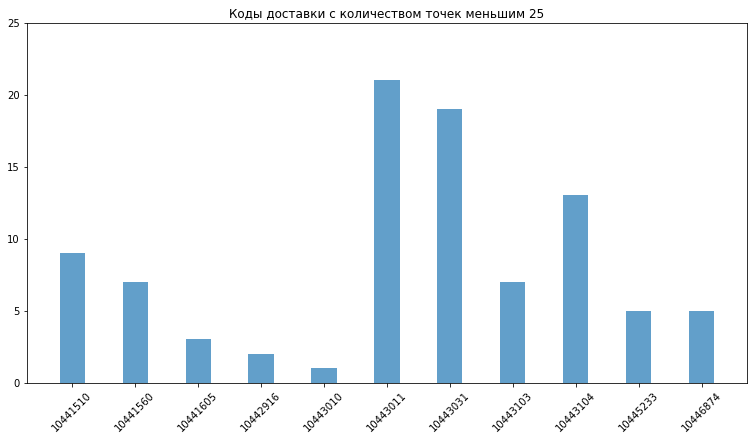

In [16]:
ship_counts = df[~df['SHIP_TO_RSS'].isna()].groupby('SHIP_TO_RSS').SWE_Store_Key.count().to_frame()
ship_counts.reset_index(inplace=True)
ship_counts.columns = ['SHIP_TO_RSS','Counts']
ship_counts['SHIP_TO_RSS'] = ship_counts['SHIP_TO_RSS'].astype(int)

fig = plt.figure(figsize=(10,5))
axes = fig.add_axes([0, 0, 1, 1])
axes.set_ylim(0, 25)
axes.bar(x = ship_counts[ship_counts['Counts']<25]['SHIP_TO_RSS'].values.astype('str'),
           height = ship_counts[ship_counts['Counts']<25]['Counts'].values, 
           width = 0.4,
           align = 'center',
           alpha = 0.7)
for tick in axes.get_xticklabels():
    tick.set_rotation(45)
axes.set_title('Коды доставки с количеством точек меньшим 25')

Сохраним список кодов адресов доставки с количеством точек меньшим 25, чтобы исключать такие коды из обучения модели.

In [17]:
ships_to_exclude = list(ship_counts['SHIP_TO_RSS'][ship_counts['Counts']<25].values)

Построим гистограмму распределения количества кодов доставки по частоте количества точек на территории. Видно, что  выборка данных не является сбалансированной, на что нужно обратить внимание.

Text(0.5, 1.0, 'Количество кодов доставки по количеству точек (гистограмма распределения, корзина: 100)')

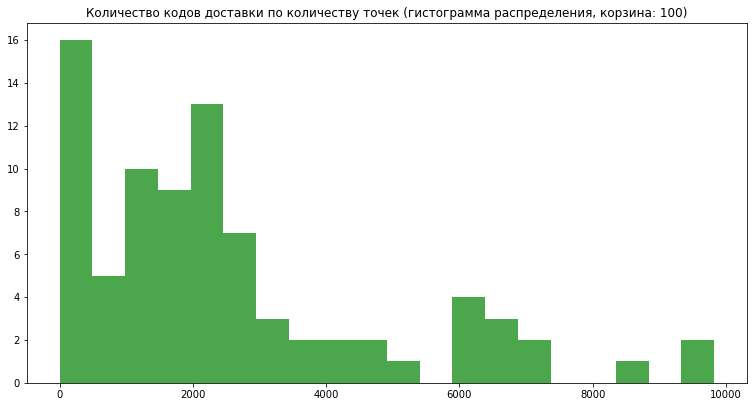

In [18]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(x = ship_counts['Counts'].values,
        bins = 20,
        color ='green',
        alpha = 0.7)
axes.set_title('Количество кодов доставки по количеству точек (гистограмма распределения, корзина: 100)')

### Анализ пропущенных значений

Посмотрим внимательнее на признаки, сразу замечаем присутствие значений "!ERR". Выясняем у бизнеса. Оказывается, из отчетной системы выгружаются значения !ERR если иерархия отсутствует.

In [19]:
df['Region'].value_counts()

South         44948
Volga         33893
Siberia       32200
East          25373
Ural          23755
North-West    23739
!ERR          20071
Moscow        17724
Name: Region, dtype: int64

Представим значения !ERR как NaN и посмотрим статистики по пропущенным значениям.

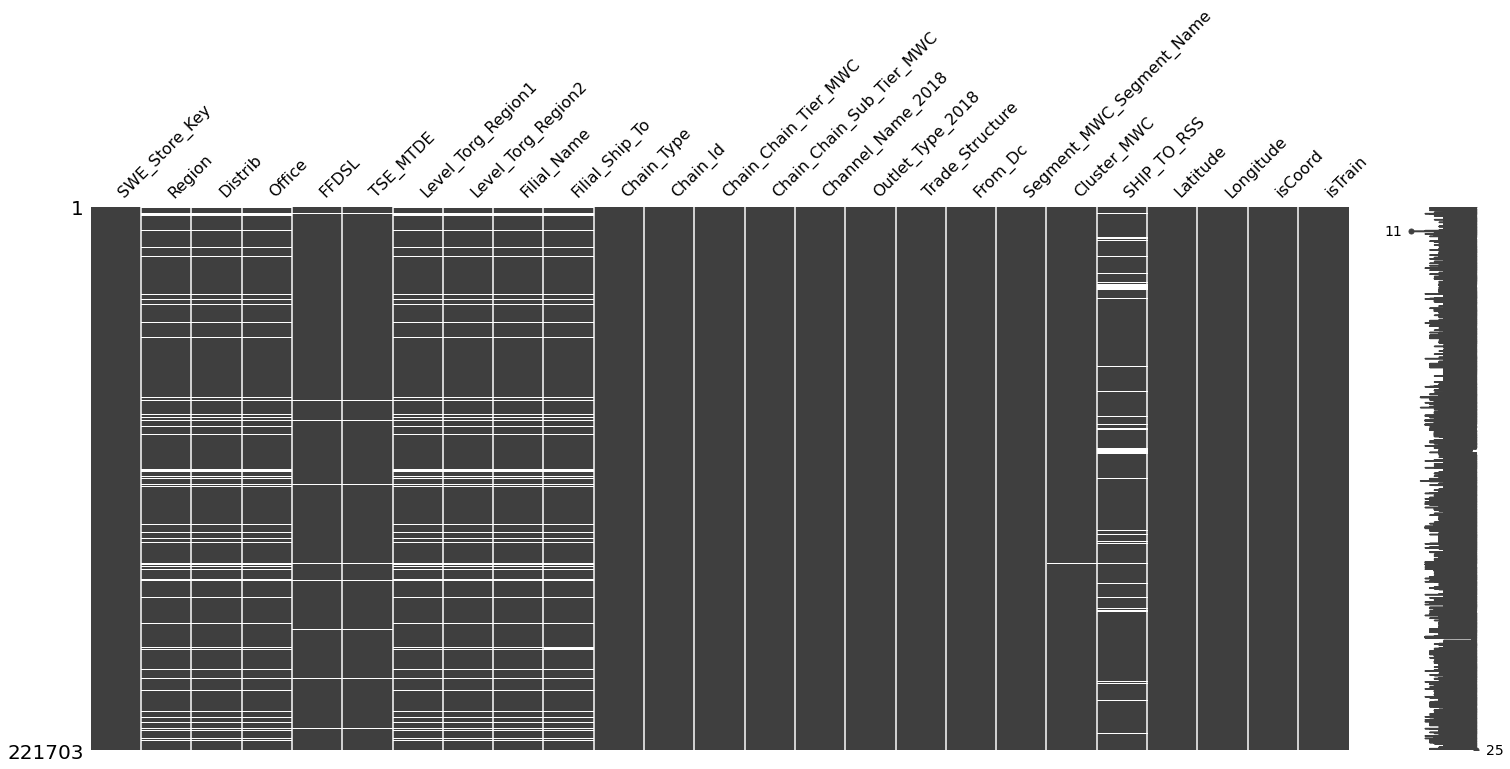

In [20]:
df.replace('!ERR', np.NaN, inplace=True)
msno.matrix(df)

Оценим пропуски количественно, для этого создадим таблицу некоторых статистик для всех признаков.

In [21]:
df_stats = pd.DataFrame(columns = ['column', 'values', 'num_unique', 'num_nan', 'pct_nan'])
tmp = pd.DataFrame()

for c in df.columns:
    tmp['column'] = [c]
    tmp['values'] = [df[c].unique()]
    tmp['num_unique'] = len(list(df[c].unique()))
    tmp['num_nan'] = df[c].isnull().sum()
    tmp['pct_nan'] = round(df[c].isnull().sum() / df.shape[0] * 100, 1)
    df_stats = df_stats.append(tmp)
    
df_stats[['column','values','num_unique','num_nan','pct_nan']]

,column,values,num_unique,num_nan,pct_nan
0,SWE_Store_Key,"[1000201031, 100050000000002, 100050000000031,...",221703,0,0.0
0,Region,"[Siberia, North-West, nan, Moscow, Ural, Volga...",8,20071,9.1
0,Distrib,"[ООО Гермес, ЗАО Денди, SF Мегаполис, nan, ООО...",62,20018,9.0
0,Office,"[MWC ООО Гермес (Новокузнецк), MWC Денди ЗАО, ...",168,20018,9.0
0,FFDSL,"[MWC FFDL Kuzbass (Vetrova Marina), MWC FFDL S...",39,4499,2.0
0,TSE_MTDE,"[MWC TSE Novokuznetsk (Sandler Kseniya), MWC T...",359,4499,2.0
0,Level_Torg_Region1,"[TL MWC: Север Кузбасса (Мокроусов Илья), TL: ...",521,20018,9.0
0,Level_Torg_Region2,[Агент МарсРигли-08 (Киселевск-2)(Погребных А....,2529,20018,9.0
0,Filial_Name,"[MWC ООО Гермес (Новокузнецк), MWC Денди ЗАО, ...",106,20019,9.0
0,Filial_Ship_To,"[10340352, 10407751, 10407053, nan, 10399270, ...",97,21163,9.5


Изучение предметной области говорит о том, что иерархия сотрудников компании (FFDSL, TSE_MTDE) задается отдельно от иерархии дистрибьюторов (куда попадают также торговые агенты Level_Torg_). Это подтверждает количество пропущенных значений (примерно 9% для иерархии дистрибьюторов и 2% для иерархии сотрудников).

Чтобы подтвердить это предположение, построем тепловую карту корреляции пропущенных значений. По ней видно, что наличие пропущенных значений в признаках иерархии дистрибьютора (Distrib, Office, Level_Torg_Region1, Level_Torg_Region1, Filial_Name, Filial_Ship_To) имеет прямую корреляцию (значение 1). Также коррелирует появление пропущенных значений для признаков иерархии сотрудников (FFDSL и TSE_MTDE). Корреляция между этими двумя группами признаков существует, но в незначительной степени.

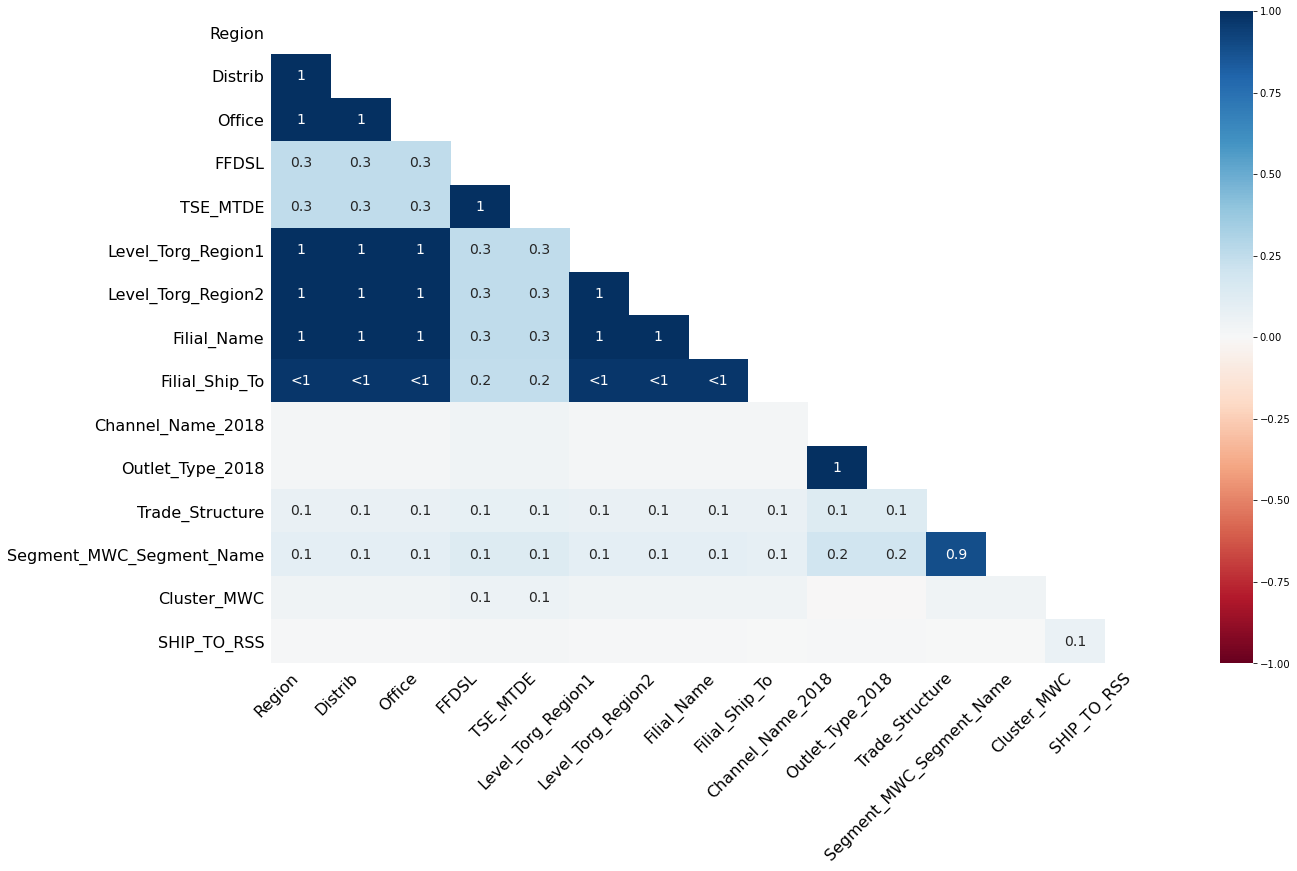

In [22]:
msno.heatmap(df)

### Сохраним текущий набор данных для дальнейших экспериментов

In [23]:
df['From_Dc'] = df['From_Dc'].astype(int)
df['Chain_Id'] = df['Chain_Id'].astype(str)
# Установить поле как индекс, тем самым исключив его из списка признаков
df.set_index('SWE_Store_Key',inplace=True)
df_for_experiments = df.copy()

## Получение модели и проведение экспериментов

### Разделение на тренировочную и валидационную выборку

При подготовке данных был добавлен технический признак isTrain, который поможет отделить данные которые нужно предсказать, от данных для обучения (которые разделим на тренировочную и валидационную выборку в соотношении 70 на 30), с контролем стратификации по SHIP_TO_RSS, при которой обеспечивается попадание значений "y" в тренировочную и валидационную выборки.

Не забудем исключить такие SHIP_TO_RSS, которые содержат меньше  25 сэмплов.

In [34]:
def get_data(drop_na=True, list_of_features=None):
    """
    Вернуть наборы данных (полный/без пропущенных значений), с учетом списка признаков
    
    Parameters:
    drop_na (boolean)        : True - удалить строки с пустыми значениями
    list_of_features (list)  : Список признаков, которые нужно оставить
        
    Returns:
    X, y, X_train, X_valid, y_train, y_valid (array-like)

    """
    df = df_for_experiments.copy()
    
    if drop_na:
        # Очистка строк с пропущенными значениями
        df = df_for_experiments.copy()
        df['SHIP_TO_RSS'].replace(np.NaN, 0, inplace=True)
        df.dropna(axis=0, inplace=True)
        df['SHIP_TO_RSS'].replace(0, np.NaN, inplace=True)

    target = ['SHIP_TO_RSS']
    service = ['isTrain','isCoord']
    if list_of_features==None:
        features = [column for column in df.columns if column not in target and column not in service]
    else:
        features = list_of_features
    X = df[(df['isTrain']==True)&(~df['SHIP_TO_RSS'].isin(ships_to_exclude))][features]
    y = df[(df['isTrain']==True)&(~df['SHIP_TO_RSS'].isin(ships_to_exclude))][target]
    y['SHIP_TO_RSS'] = y['SHIP_TO_RSS'].astype(int)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    print('Размер выборки train: {0}, valid: {1}'.format(X_train.shape[0], X_valid.shape[0]))
    
    return X, y, X_train, X_valid, y_train, y_valid

In [25]:
X, y, X_train, X_valid, y_train, y_valid = get_data(drop_na=False)

Размер выборки train: 144267, valid: 61829


### Обучение

Для обучения модели используем конвейер данных (Pipeline) в котором выполним замену пропущенных значений, а также кодирование в One Hot. Конвейеры упрощают код, а также выполняют работу в разреженных матрицах. Разряженные матрицы важны когда имеется много категорийных данных, как в нашем случае.

In [26]:
def get_pipeline(X_train, y_train, classifier, do_fit=True):
    """
    Подготовить Pipeline

    Parameters:
    X_train (array-like)  : Набор данных для обучения
    y_train (array-like)  : Целевые значения для обучения
    classifier            : Классификатор, например, rfc
    do_fit (boolean)      : True - выполнить обучение
        
    Returns:
    sklearn.pipeline.Pipeline

    """
    
    cat_features = X_train.select_dtypes(include=['object']).columns  # Categorical
    num_features = X_train.select_dtypes(exclude=['object']).columns  # Numeric
    
    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ])
    num_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
    ])
    preprocessing = ColumnTransformer(
        [('cat', cat_pipe, cat_features),
         ('num', num_pipe, num_features),
        ])
    pipeline = Pipeline([
        ('preprocess', preprocessing),
        ('classifier', classifier),
    ])
    if do_fit:
        pipeline.fit(X_train, y_train.values.ravel())
        
    return pipeline

### Выбор классификатора
Для задачи классификации удобно использовать классификатор RandomForestClassifier. По моему опыту этот ансамблевый метод часто показывает лучшие результаты обучения. Согласно https://ru.wikipedia.org/wiki/Random_forest#%D0%94%D0%BE%D1%81%D1%82%D0%BE%D0%B8%D0%BD%D1%81%D1%82%D0%B2%D0%B0 имеет следующие достоинства:
- Способность эффективно обрабатывать данные с большим числом признаков и классов.
- Нечувствительность к масштабированию (и вообще к любым монотонным преобразованиям) значений признаков.
- Одинаково хорошо обрабатываются как непрерывные, так и дискретные признаки.

In [27]:
clf = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)
model = get_pipeline(X_train, y_train, clf)
y_pred = model.predict(X_valid)

### Выбор метрики

Для мультиклассовой классификации, в условиях несбалансированной выборки, допустимо использовать несколько различных метрик https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics. Для нашей задачи будем использовать метрику balanced_accuracy_score, которая определяется как средняя величина полноты (recall), полученная по каждому классу.

В случае, если классификатор работает одинаково хорошо для всех классов, то эта метрика работает как обычная точность, то есть отношение правильных предсказаний к общему количеству предсказаний. Если же обычная точность выше вероятности только потому, что классификатор использует несбалансированный набор тестов, тогда сбалансированная точность, в зависимости от ситуации, снизится до 1/n_classes (https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score).

In [28]:
print('balanced accuracy score: {:.3f}'.format(balanced_accuracy_score(y_valid, y_pred)))

balanced accuracy score: 0.989


Как видно, сразу получено очень хорошее значение метрики. Попробуем убедиться, что этот результат действительно хорош, а также, возможно ли его улучшить?

### Эксперимент. Как отсутствие иерархий влияет на ошибки предсказания?

Попробуем подтвердить предположение, что отсутствие иерархий влияет на количество ошибок. Для этого соберем набор данных с агрегированной информацией по каждому классу SHIP_TO_RSS.

In [29]:
def get_prediction_result_pivot_table(X, X_train, X_valid, y_valid, hierarchy=True):
    """
    Строит сводную таблицу для количественного анализа предсказаний модели

    Parameters:
    X (array-like)      : Исходный набор признаков без целевого
    X_train (array-like): Набор признаков для обучения
    X_valid (array-like): Набор признаков для валидации
    y_valid (array-like): Целевой признак для валидации
    hierarchy (boolean) : True - включать в анализ расчеты по иерархиям
        
    Returns:
    pandas.DataFrame    : Сводная таблица

    """
    result_df = pd.DataFrame()

    # Сколько всего записей в тестовом наборе данных
    test_data = X.copy()
    test_data['SHIP_TO_RSS'] = y['SHIP_TO_RSS']
    test_data.groupby('SHIP_TO_RSS').SHIP_TO_RSS.count()
    result_df['SHIP_TO_RSS'] = test_data.groupby('SHIP_TO_RSS').SHIP_TO_RSS.count()
    result_df.columns = ['test_samples_counts']

    # Подсчитаем сколько записей в тренировочном наборе
    train_data = X_train.copy()
    train_data['SHIP_TO_RSS'] = y_train['SHIP_TO_RSS']
    train_data_df = train_data.groupby('SHIP_TO_RSS').SHIP_TO_RSS.count().to_frame()
    train_data_df.columns = ['train_samples_counts']
    result_df.loc[train_data_df.index,'train_samples_counts'] = \
        train_data_df['train_samples_counts']

    # Подсчитаем сколько записей в валидационном наборе
    valid_data = X_valid.copy()
    valid_data['SHIP_TO_RSS'] = y_valid['SHIP_TO_RSS']
    valid_data_df = valid_data.groupby('SHIP_TO_RSS').SHIP_TO_RSS.count().to_frame()
    valid_data_df.columns = ['valid_samples_counts']
    result_df.loc[valid_data_df.index,'valid_samples_counts'] = \
        valid_data_df['valid_samples_counts']

    # Подсчитаем количество ошибочных предсказаний
    y_compare = y_valid.copy()
    y_compare['SHIP_TO_RSS_PRED'] = y_pred
    y_wrong_predicted = y_compare[y_compare['SHIP_TO_RSS']!=y_compare['SHIP_TO_RSS_PRED']].copy()
    y_wrong_predicted_df = y_wrong_predicted.groupby('SHIP_TO_RSS').SHIP_TO_RSS.count().to_frame()
    y_wrong_predicted_df.columns = ['wrong_predicted_counts']
    result_df.loc[y_wrong_predicted_df.index,'wrong_predicted_counts'] = \
        y_wrong_predicted_df['wrong_predicted_counts']

    # Ошибка в процентах от количества записей в проверочном наборе данных
    result_df['wrong_predicted_percentage'] = \
        result_df['wrong_predicted_counts'] / \
        result_df['valid_samples_counts'] * 100

    if hierarchy:
        # Посчитаем сколько всего записей с иерархиями дистрибьюторов и сотрудников
        test_data['dist_hierarchy_exists'] = ~test_data['Region'].isna()
        test_data['associates_hierarchy_exists'] = ~test_data['FFDSL'].isna()

        dist_hierarchy_exists_df = test_data[test_data['dist_hierarchy_exists']==True]. \
            groupby(['SHIP_TO_RSS','dist_hierarchy_exists']).dist_hierarchy_exists.count().to_frame()
        dist_hierarchy_exists_df.columns = ['dist_hierarchy_exists_counts']
        dist_hierarchy_exists_df.reset_index(inplace=True)
        dist_hierarchy_exists_df.set_index('SHIP_TO_RSS',inplace=True)
        dist_hierarchy_exists_df.drop('dist_hierarchy_exists',axis=1,inplace=True)

        associates_hierarchy_exists_df = test_data[test_data['associates_hierarchy_exists']==True]. \
            groupby(['SHIP_TO_RSS','associates_hierarchy_exists']).associates_hierarchy_exists.count().to_frame()
        associates_hierarchy_exists_df.columns = ['associates_hierarchy_exists_counts']
        associates_hierarchy_exists_df.reset_index(inplace=True)
        associates_hierarchy_exists_df.set_index('SHIP_TO_RSS',inplace=True)
        associates_hierarchy_exists_df.drop('associates_hierarchy_exists',axis=1,inplace=True)

        result_df.loc[dist_hierarchy_exists_df.index,'dist_hierarchy_exists_counts'] = \
            dist_hierarchy_exists_df['dist_hierarchy_exists_counts']
        result_df.loc[associates_hierarchy_exists_df.index,'associates_hierarchy_exists_counts'] = \
            associates_hierarchy_exists_df['associates_hierarchy_exists_counts']

        result_df['dist_hierarchy_exists_percentage'] = \
            result_df['dist_hierarchy_exists_counts'] / \
            result_df['test_samples_counts'] * 100

        result_df['associates_hierarchy_exists_percentage'] = \
            result_df['associates_hierarchy_exists_counts'] / \
            result_df['test_samples_counts'] * 100

        fields_to_output = ['test_samples_counts','wrong_predicted_percentage',
                            'dist_hierarchy_exists_percentage','associates_hierarchy_exists_percentage']
        return result_df.sort_values('wrong_predicted_percentage',ascending=False)[fields_to_output][:15]
    else:
        fields_to_output = ['test_samples_counts','wrong_predicted_percentage']
        return result_df.sort_values('wrong_predicted_percentage',ascending=False)[fields_to_output][:15]

In [30]:
df_prediction_result = get_prediction_result_pivot_table(X, X_train, X_valid, y_valid, hierarchy=True)

Построим графики с типом bar для первых 15-ти классов с наибольшей относительной ошибкой.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000226A58E2188>,
      dtype=object)

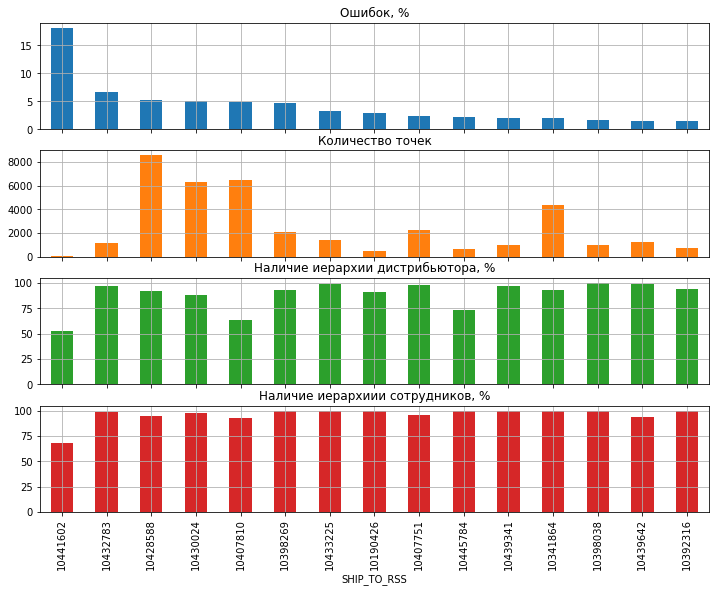

In [31]:
df_prediction_result \
    .loc[:,['wrong_predicted_percentage','test_samples_counts','dist_hierarchy_exists_percentage',
            'associates_hierarchy_exists_percentage']] \
        .sort_values('wrong_predicted_percentage',ascending=False)[:15].plot(
            kind='bar',
            grid = True, 
            subplots = True, 
            title = ['Ошибок, %','Количество точек','Наличие иерархии дистрибьютора, %',
                     'Наличие иерархиии сотрудников, %'], 
            legend = False,
            figsize=(12,9))

In [32]:
df_prediction_result

,test_samples_counts,wrong_predicted_percentage,dist_hierarchy_exists_percentage,associates_hierarchy_exists_percentage
SHIP_TO_RSS,,,,
10441602,38,18.181818,52.631579,68.421053
10432783,1112,6.586826,96.762590,99.010791
10428588,8553,5.183164,91.815737,94.528236
10430024,6310,4.965663,88.399366,97.400951
10407810,6491,4.879301,63.842243,92.204591
10398269,2093,4.617834,92.881032,99.665552
10433225,1446,3.225806,99.031812,99.930844
10190426,470,2.836879,90.851064,99.787234
10407751,2263,2.356406,98.188246,96.111357


Убеждаемся, что не смотря на то, что для класса с максимальной ошибкой отсутствие иерархий ярко выражено, для последующих классов мы видим, что относительная ошибка уменьшается, а наличие иерархий не имеет выраженного  патерна. Таким образом, делаем вывод, что наличие иерархий не оказывает заметного влияния на ошибки.

### Эксперимент. Исключение данных с пропущенными значениями

Поскольку пропущенные значения разных признаков имеют одинаковую специальную метку, в момент кодировки One Hot Encoding, это может отрицательно влиять на процесс обучения. Попробуем откинуть данные с пропущенными значениями, тем более, что их не больше 10% от общего количества.

In [36]:
X, y, X_train, X_valid, y_train, y_valid = get_data()
model = get_pipeline(X_train, y_train, clf)
y_pred = model.predict(X_valid)
print('balanced accuracy score: {:.3f}'.format(balanced_accuracy_score(y_valid, y_pred)))

Размер выборки train: 129308, valid: 55419
balanced accuracy score: 0.993


Мы получили ещё больший score! Посмотрим на график ошибок.

In [37]:
df_prediction_result = get_prediction_result_pivot_table(X, X_train, X_valid, y_valid, hierarchy=False)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000226A490BF48>,
      dtype=object)

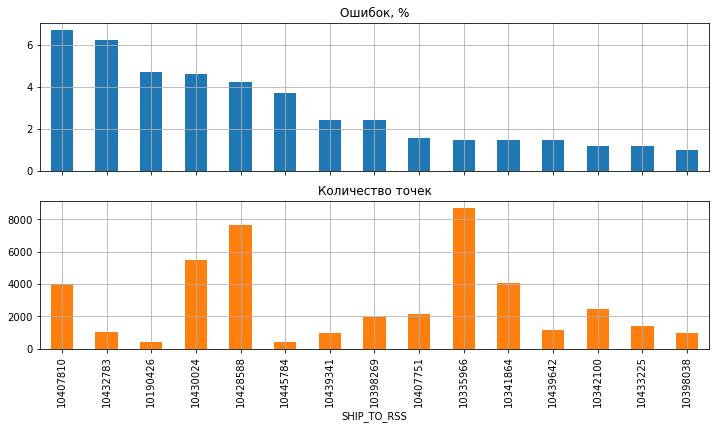

In [38]:
df_prediction_result \
    .loc[:,['wrong_predicted_percentage','test_samples_counts']] \
        .sort_values('wrong_predicted_percentage',ascending=False)[:15].plot(
            kind='bar',
            grid = True, 
            subplots = True, 
            title = ['Ошибок, %','Количество точек'], 
            legend = False,
            figsize=(12,6))

In [39]:
df_prediction_result

,test_samples_counts,wrong_predicted_percentage
SHIP_TO_RSS,,
10407810,4021,6.716418
10432783,1065,6.250000
10190426,423,4.724409
10430024,5497,4.608854
10428588,7618,4.245077
10445784,446,3.731343
10439341,967,2.413793
10398269,1940,2.405498
10407751,2141,1.557632


В результате эксперимента принимаем подход с отбрасыванием строк с пропущенными значениями, т.к. точность модели повышается (0.993 vs 0.989).

### Эксперимент. Определение важности признаков

Воспользуемся специальным приемом, чтобы получить из конвейера информацию об исходных признаках, о новых One-Hot признаках, а также о суммарной важности каждого One-Hot признака в финальное предсказание.

In [40]:
cat_features = X.select_dtypes(include=['object']).columns  # Categorical
num_features = X.select_dtypes(exclude=['object']).columns  # Numeric

# Получить объект OneHotEncoder
ohe = (model.named_steps['preprocess']
       .named_transformers_['cat']
       .named_steps['onehot'])

# Получить названия новых One Hot признаков
cat_ohe_feature_names = ohe.get_feature_names(input_features=cat_features)

# К One Hot признакам присоединить числовые признаки, которые участвовали в обучении модели
feature_names = np.append(cat_ohe_feature_names, num_features)

# Вместо уникальных названий One Hot признаков получить массив исходных названий признаков той же длины
features_raw = []
for fname, fval  in zip(cat_features,ohe.categories_):
    features_raw = np.append(features_raw, [fname] * len(fval))
features_raw = np.append(features_raw, num_features)

# Получить объект с классификатором
rfc = model.named_steps['classifier']

# Создать DataFrame с тремя столбцами:
# исходный признак, соответствующий One Hot признак, важность признака из классификатора
df_imp = pd.DataFrame(
        {"Feature":features_raw,
         "FeatureName":feature_names,
         "Importance":rfc.feature_importances_}
    ).sort_values(["Importance"], ascending=False)

Интересный факт, что именно информация о иерархии доистрибьютора и иерархии сотрудников оказывают наибольшее влияние в итоговый результат предсказания. Координаты точки идут сразу после этих признаков.

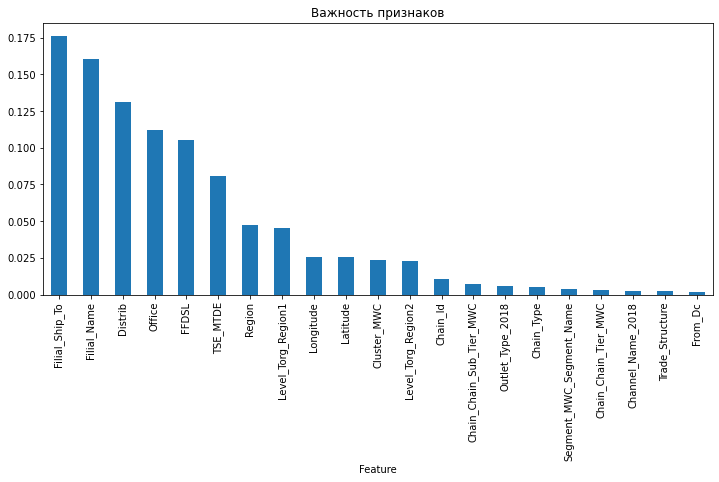

In [41]:
df_imp.groupby('Feature').Importance.sum().sort_values(ascending=False) \
    .plot(kind='bar',figsize=(12,5),title='Важность признаков')

In [42]:
# Сохраним список важности признаков, отсортированный в порядке убывания важности
feature_importance_list = list(df_imp.groupby('Feature').Importance.sum().sort_values(ascending=False).index)

### Эксперимент. Зависимость точности модели от количества признаков - 1

##### Исключить последовательно признаки в порядке возрастания важности

Используя последний сплит набора данных, построим график зависимости точности модели от количества признаков, исключая последовательно признаки в порядке возрастания важности. 

In [43]:
X_train_reduced = X_train.copy()
X_valid_reduced = X_valid.copy()

feat_len = len(feature_importance_list)
score_list_1 = []
feat_number_list_1 = []
for num in range(feat_len - 3):
    # Оставить первые feat_len - num признаков
    features = feature_importance_list[:feat_len - num]
    X_train_reduced = X_train_reduced[features]
    X_valid_reduced = X_valid_reduced[features]

    model = get_pipeline(X_train_reduced, y_train, clf)
    y_pred = model.predict(X_valid_reduced)
    score_list_1.append(balanced_accuracy_score(y_valid, y_pred))
    feat_number_list_1.append(feat_len - num)
    print('Количество признаков: {0}, точность: {1}'.format(feat_len - num, score_list_1[-1:]))

Количество признаков: 21, точность: [0.9932693953461197]
Количество признаков: 20, точность: [0.9928346358274528]
Количество признаков: 19, точность: [0.9925292744625045]
Количество признаков: 18, точность: [0.9933445887713576]
Количество признаков: 17, точность: [0.9919213841183879]
Количество признаков: 16, точность: [0.993207606658012]
Количество признаков: 15, точность: [0.9932210972363964]
Количество признаков: 14, точность: [0.9922888560319849]
Количество признаков: 13, точность: [0.9902410551725511]
Количество признаков: 12, точность: [0.9774508614915766]
Количество признаков: 11, точность: [0.9762504512319433]
Количество признаков: 10, точность: [0.9763720664439522]
Количество признаков: 9, точность: [0.9737083336757296]
Количество признаков: 8, точность: [0.9766275309041849]
Количество признаков: 7, точность: [0.9738536049652377]
Количество признаков: 6, точность: [0.9737960099111093]
Количество признаков: 5, точность: [0.9662178631678111]
Количество признаков: 4, точность: [0

Text(0.5, 1.0, 'Зависимость точности модели от количества признаков.\nИсключение признаков идёт в порядке увеличения важности - слева на право по списку:\nFrom_Dc, Trade_Structure, Channel_Name_2018, Chain_Chain_Tier_MWC, Segment_MWC_Segment_Name, Chain_Type,\nOutlet_Type_2018, Chain_Chain_Sub_Tier_MWC, Chain_Id, Level_Torg_Region2, Cluster_MWC, Latitude, Longitude,\nLevel_Torg_Region1, Region, TSE_MTDE, FFDSL, Office, Distrib, Filial_Name, Filial_Ship_To')

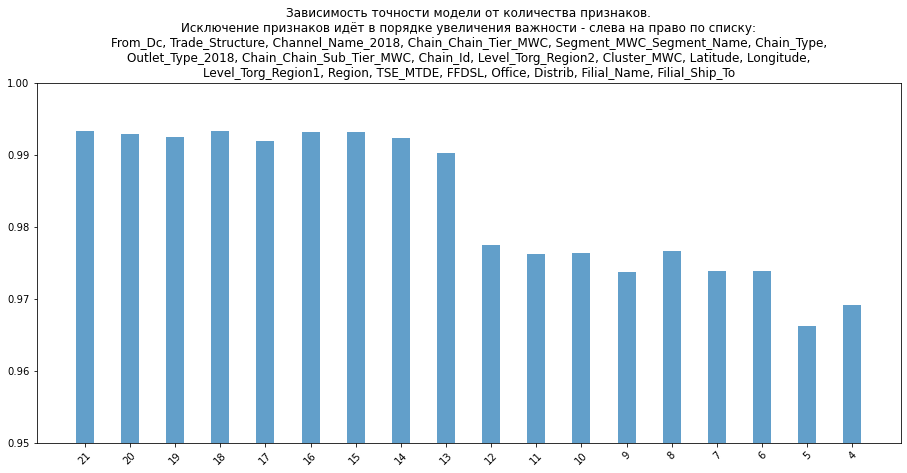

In [44]:
fig = plt.figure(figsize=(12,5))
axes = fig.add_axes([0, 0, 1, 1])
axes.set_ylim(0.95, 1)
axes.bar(x = [str(x) for x in feat_number_list_1],
           height = score_list_1,
           width = 0.4,
           align = 'center',
           alpha = 0.7)
for tick in axes.get_xticklabels():
    tick.set_rotation(45)
axes.set_title("""Зависимость точности модели от количества признаков.
Исключение признаков идёт в порядке увеличения важности - слева на право по списку:
{0},
{1},
{2}""".format(', '.join([str(item) for item in feature_importance_list[::-1][:6]]),
              ', '.join([str(item) for item in feature_importance_list[::-1][6:13]]),
              ', '.join([str(item) for item in feature_importance_list[::-1][13:]])))

In [45]:
top_features = 18

Результат эксперимента показывает, что если оставить только 18 самых важных признаков, точность модели не будет потеряна.

### Эксперимент. Зависимость точности модели от количества признаков - 2

##### Исключить последовательно признаки в порядке убывания важности

Построим график зависимости точности модели от количества признаков, исключая последовательно признаки _в порядке снижения важности_ (т.е. первым исключить самый важный). Работаем с определенными на предыдущем шаге самыми важными признаками (первые top_features).

In [46]:
X_train_reduced = X_train.copy()
X_valid_reduced = X_valid.copy()

feat_len = len(feature_importance_list[:top_features])
score_list_2 = []
feat_number_list_2 = []
for num in range(feat_len - 3):
    # Оставить последние feat_len - (feat_len - num) признаков
    features = feature_importance_list[:top_features][num:feat_len]
    X_train_reduced = X_train_reduced[features]
    X_valid_reduced = X_valid_reduced[features]

    model = get_pipeline(X_train_reduced, y_train, clf)
    y_pred = model.predict(X_valid_reduced)
    score_list_2.append(balanced_accuracy_score(y_valid, y_pred))
    feat_number_list_2.append(feat_len - num)
    print('Количество признаков: {0}, точность: {1}'.format(feat_len - num, score_list_2[-1:]))

Количество признаков: 18, точность: [0.9933445887713576]
Количество признаков: 17, точность: [0.9930899380676538]
Количество признаков: 16, точность: [0.9931318039212971]
Количество признаков: 15, точность: [0.9928843709990213]
Количество признаков: 14, точность: [0.9910988776667662]
Количество признаков: 13, точность: [0.9921209934788072]
Количество признаков: 12, точность: [0.9919894189834678]
Количество признаков: 11, точность: [0.9912369395566729]
Количество признаков: 10, точность: [0.9849093624516252]
Количество признаков: 9, точность: [0.9737601997869675]
Количество признаков: 8, точность: [0.9559495442340933]
Количество признаков: 7, точность: [0.9398610569539649]
Количество признаков: 6, точность: [0.220083565601267]
Количество признаков: 5, точность: [0.14293771714501532]
Количество признаков: 4, точность: [0.11012932563394585]


Text(0.5, 1.0, 'Зависимость точности модели от количества признаков.\nИсключение признаков идёт в порядке снижения важности - слева на право по списку:\nFilial_Ship_To, Filial_Name, Distrib, Office, FFDSL, TSE_MTDE, Region, Level_Torg_Region1, Longitude, Latitude, Cluster_MWC\nLevel_Torg_Region2, Chain_Id, Chain_Chain_Sub_Tier_MWC, Outlet_Type_2018, Chain_Type, Segment_MWC_Segment_Name, Chain_Chain_Tier_MWC')

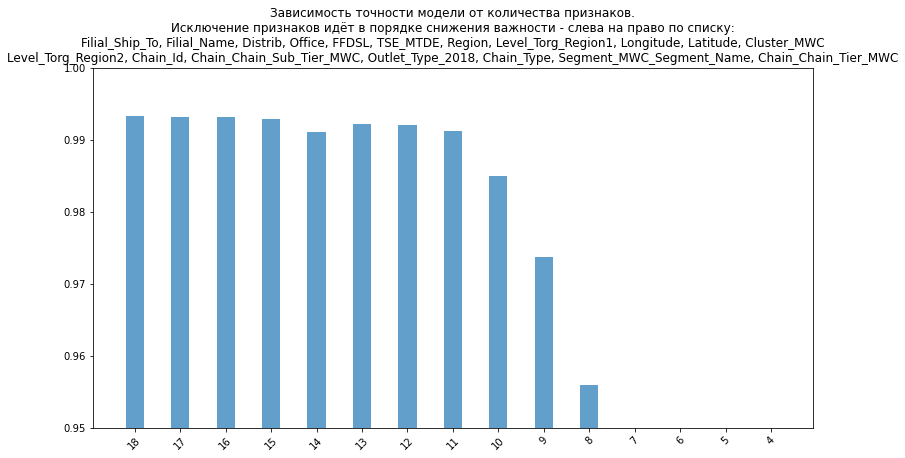

In [47]:
# features_to_exclude_ = list(df_imp.groupby('Feature').Importance.sum().sort_values(ascending=False).index)[:15]

fig = plt.figure(figsize=(10,5))
axes = fig.add_axes([0, 0, 1, 1])
axes.set_ylim(0.95, 1)
axes.bar(x = [str(x) for x in feat_number_list_2],
           height = score_list_2, 
           width = 0.4,
           align = 'center',
           alpha = 0.7)
for tick in axes.get_xticklabels():
    tick.set_rotation(45)
axes.set_title("""Зависимость точности модели от количества признаков.
Исключение признаков идёт в порядке снижения важности - слева на право по списку:
{0}
{1}""".format(', '.join([str(item) for item in feature_importance_list[:top_features][:11]]),
              ', '.join([str(item) for item in feature_importance_list[:top_features][11:]])))

Вввод из этого эксперимента: исключение самых важных признаков снижает точность модели.

### Эксперимент. Подбор параметров модели с помощью GridSearchCV

Воспользуемся GridSearchCV, чтобы найти лучшие параметры для модели.

In [49]:
# Получим полный набор данных X, y без пропущенных значений
X, y, _, _, _, _ = get_data(list_of_features=feature_importance_list[:18])
clf = RandomForestClassifier(random_state=42, n_jobs=-1)
model = get_pipeline(X, y, clf, do_fit=False)

parameters = {
    'classifier__n_estimators'            : [10, 100],
    'classifier__max_depth'               : [None, 30],
    'classifier__min_samples_split'       : [2, 4],
    'classifier__random_state'            : [42],
}

grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=10)

print("Начало поиска лучших параметров...")
print("pipeline:", [name for name, _ in model.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X, y)
print("Выполнено за %0.3f сек." % (time() - t0))
print()

print("Лучший score: %0.3f" % grid_search.best_score_)
print("Лучший набор параметров:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Размер выборки train: 129308, valid: 55419
Начало поиска лучших параметров...
pipeline: ['preprocess', 'classifier']
parameters:
{'classifier__max_depth': [None, 30],
 'classifier__min_samples_split': [2, 4],
 'classifier__n_estimators': [10, 100],
 'classifier__random_state': [42]}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:  5.4min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:  5.5min remaining:   46.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  6.1min finished


Выполнено за 409.425 сек.

Лучший score: 0.983
Лучший набор параметров:
	classifier__max_depth: None
	classifier__min_samples_split: 2
	classifier__n_estimators: 100
	classifier__random_state: 42


### Эксперимент. Оценка точности модели в кросс-валидации

Настал момент оценить насколько хорошо данная модель будет работать на практике. Для этого используем технику перекрестной проверки.

In [50]:
# Получим полный набор данных X, y без пропущенных значений
X, y, _, _, _, _ = get_data(list_of_features=feature_importance_list[:18])
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model = get_pipeline(X, y, clf, do_fit=False)
scores = cross_val_score(model, X, y, cv=3)
print('Средняя оценка при кросс-валидации: %.3f' % (scores.mean()))

Размер выборки train: 129308, valid: 55419
Средняя оценка при кросс-валидации: 0.981


Как и ожидалось, при кросс-валидации средний скор получился немного меньше.

## Выводы

В процессе выполнения работы входные данные были проанализированы и очищены. Для ответа на некоторые вопросы, привлекался человек из бизнеса со знанием предметной области. Разработан алгоритм восстановления координат точек по координатам соседних точек. Обнаружены скрытые пропущенные значения в иерархиях дистрибьюторов и сотрудников. Проанализирован целевой признак. Выполнен анализ пропущенных значений.

Выбрана метрика для оценки и классификатор. Полученный набор данных является несбалансированным, поэтому для оценки модели была использована метрика balanced accuracy score, которая учитывает несбалансированность классов. В процессе моделирования было достигнуто значение метрики больше 0.98, при этом одинаково хорошая оценка достигалась при использовании разных классификаторов, например, Logistic Regression. Было решено остановиться на алгоритме  Random Forest Classifier, который показал максимальное значение.

Анализ важности признаков показал, что вклад признаков, которые относятся к иерархиям дистрибьюторов и сотрудников, выше, чем координат торговых точек. При этом не подтверждено существенное влияние отсутствия иерархий  на правильность ответа. С другой стороны мы убедились, что малое значение (до 40) записей в классе, приводит к низкой точности предсказания. Из-за этого последовала рекомендация предупреждать пользователя о наличии таких классов, но не предстказывать их.

Тогда было решено удалить строки с пропущенными значениями, что позволило улучшить точность модели. Дальнейших эксперименты проводились с данными без пропущенных значений.

Были проведен эксперименты для выявления зависимости точности модели от количества признаков. Обнаружилось, что можно отбросить несколько признаков с минимальной важностью, без влияния на точность модели.

Финально был выполнен подбор параметров модели с помощью Grid Search, а также путем техники перекрестной проверки оценена способность модели работать на практике.